In [1]:
# IMPORTS

import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import json
from scipy.stats import kurtosis, skew
import warnings



ModuleNotFoundError: No module named 'seaborn'

In [140]:
# DATA 

df_recharge = 'ChargeEvents_full.csv'
df_recharge = pd.read_csv(df_recharge)
warnings.filterwarnings('ignore')

In [141]:
# PRE-PROCESSAMENTO

# Criando colunas e filtrando o df

colunas_objetivas = ['ModeloCarro','ChargeType','DurationTicks','StartStateOfCharge','EndStateOfCharge','MeasuredBatteryEnergyInKwh','PeakPowerKw']
df_recharge_filter = df_recharge[colunas_objetivas]
df_recharge_filter['DeltaSOC'] = 100 - df_recharge_filter['StartStateOfCharge']
df_recharge_filter['DurationHours'] = df_recharge_filter['DurationTicks'] / 36000000000

df_recharge_filter.info()

# Calcular o percentual de NA por coluna

df_recharge_filter.isna().mean() * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282159 entries, 0 to 282158
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ModeloCarro                 282159 non-null  object 
 1   ChargeType                  282159 non-null  object 
 2   DurationTicks               282159 non-null  int64  
 3   StartStateOfCharge          282020 non-null  float64
 4   EndStateOfCharge            282020 non-null  float64
 5   MeasuredBatteryEnergyInKwh  282159 non-null  float64
 6   PeakPowerKw                 254963 non-null  float64
 7   DeltaSOC                    282020 non-null  float64
 8   DurationHours               282159 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 19.4+ MB


ModeloCarro                   0.000000
ChargeType                    0.000000
DurationTicks                 0.000000
StartStateOfCharge            0.049263
EndStateOfCharge              0.049263
MeasuredBatteryEnergyInKwh    0.000000
PeakPowerKw                   9.638537
DeltaSOC                      0.049263
DurationHours                 0.000000
dtype: float64

In [142]:
# Analisando que estratégia de replace usar no PeakPowerKw devido ao valor significativo de quase 10% dos dados

df_recharge_filter['PeakPowerKw'].describe()

count    254963.000000
mean          3.746863
std          10.318797
min        -197.875000
25%          -0.392045
50%           0.000000
75%           6.356818
max         115.080681
Name: PeakPowerKw, dtype: float64

In [143]:
df_recharge_filter = df_recharge_filter.dropna(how='all') # Removendo todos NA visto que usar o replace pela média ou pela moda ficaria inviável

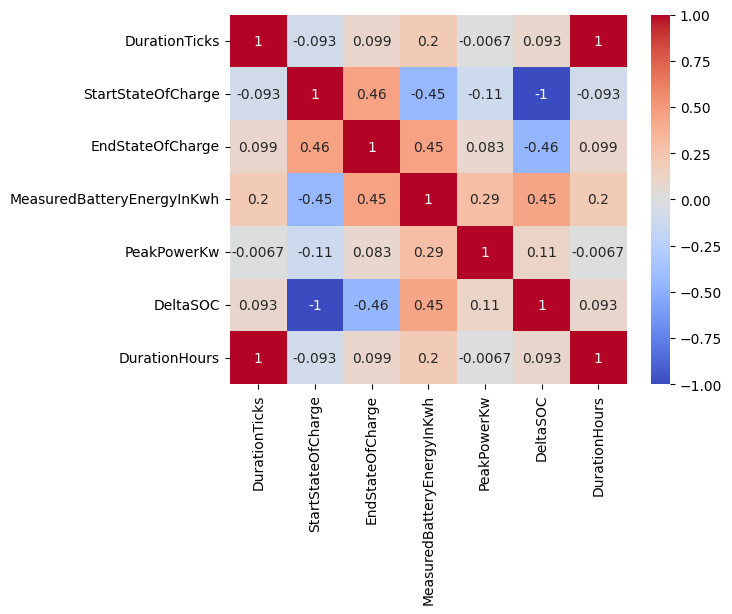

In [144]:
# Matriz de correlação

matriz_correlacao = df_recharge_filter.drop(columns=['ModeloCarro','ChargeType']).corr()

sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm')

plt.show()

In [145]:
# Normalizar os textos dos modelos dos carros

df_recharge_filter['ModeloCarro'] = df_recharge_filter['ModeloCarro'].str.strip().str.upper()

# Agrupar por Modelo de carro e tipo de recarga 

df_recharge_grouped = df_recharge_filter.groupby(['ModeloCarro', 'ChargeType']).size().reset_index(name='Ocorrências')

# Total de ocorrências

total_ocorrencias = df_recharge_grouped['Ocorrências'].sum()

# Percentual de cada grupo

df_recharge_grouped['Percentual'] = (df_recharge_grouped['Ocorrências'] / total_ocorrencias) * 100

df_recharge_grouped = df_recharge_grouped.sort_values(by='Percentual', ascending=False)

df_recharge_grouped.head(100)

,ModeloCarro,ChargeType,Ocorrências,Percentual
26,KANGOO Z.E. MAXI 2 LUGARES 2P,AC,95989,34.019471
10,E-JUMPY,AC,59149,20.963003
6,E-EXPERT,AC,21082,7.471674
4,E- SCUDO 4P,AC,20140,7.137819
25,JAC IEV1200T AT 4X2 2P,DC,19058,6.754348
24,JAC IEV1200T AT 4X2 2P,AC,10672,3.782265
12,E-JUMPY FURGÃO 2P,AC,8926,3.163465
0,BYD ET3,AC,8618,3.054306
8,E-EXPERT ELÉTRICO 2P,AC,8261,2.927782
20,"E-TRANSIT FURGÃO L3H3 12,4M ELÉT 68KW 4P",DC,5743,2.035377


In [146]:
# Ajustando os textos redundantes 

df_recharge_filter['ModeloCarro'] = df_recharge_filter['ModeloCarro'].replace({
    'JAC IEV1200T AT 4X2 2P': 'JAC IEV1200T',
    'JAC IEV1200T AT 4x2 2P': 'JAC IEV1200T',
    'E-EXPERT ELÉTRICO 2P': 'E-EXPERT',
    'E-JUMPY FURGÃO 2P': 'E-JUMPY'
})

df_recharge_grouped.sort_values(by='Percentual', ascending=False)

df_recharge_grouped.head(100)

,ModeloCarro,ChargeType,Ocorrências,Percentual
26,KANGOO Z.E. MAXI 2 LUGARES 2P,AC,95989,34.019471
10,E-JUMPY,AC,59149,20.963003
6,E-EXPERT,AC,21082,7.471674
4,E- SCUDO 4P,AC,20140,7.137819
25,JAC IEV1200T AT 4X2 2P,DC,19058,6.754348
24,JAC IEV1200T AT 4X2 2P,AC,10672,3.782265
12,E-JUMPY FURGÃO 2P,AC,8926,3.163465
0,BYD ET3,AC,8618,3.054306
8,E-EXPERT ELÉTRICO 2P,AC,8261,2.927782
20,"E-TRANSIT FURGÃO L3H3 12,4M ELÉT 68KW 4P",DC,5743,2.035377


In [147]:
ranking_modelos_signigicantes = ['ModeloCaKANGOO Z.E. MAXI 2 LUGARES 2Prro','E-JUMPY','E-EXPERT','E- SCUDO 4P','JAC IEV1200T','BYD ET3']
df_recharge_filter_ranking = df_recharge_filter[df_recharge_filter['ModeloCarro'].isin(ranking_modelos_signigicantes)]

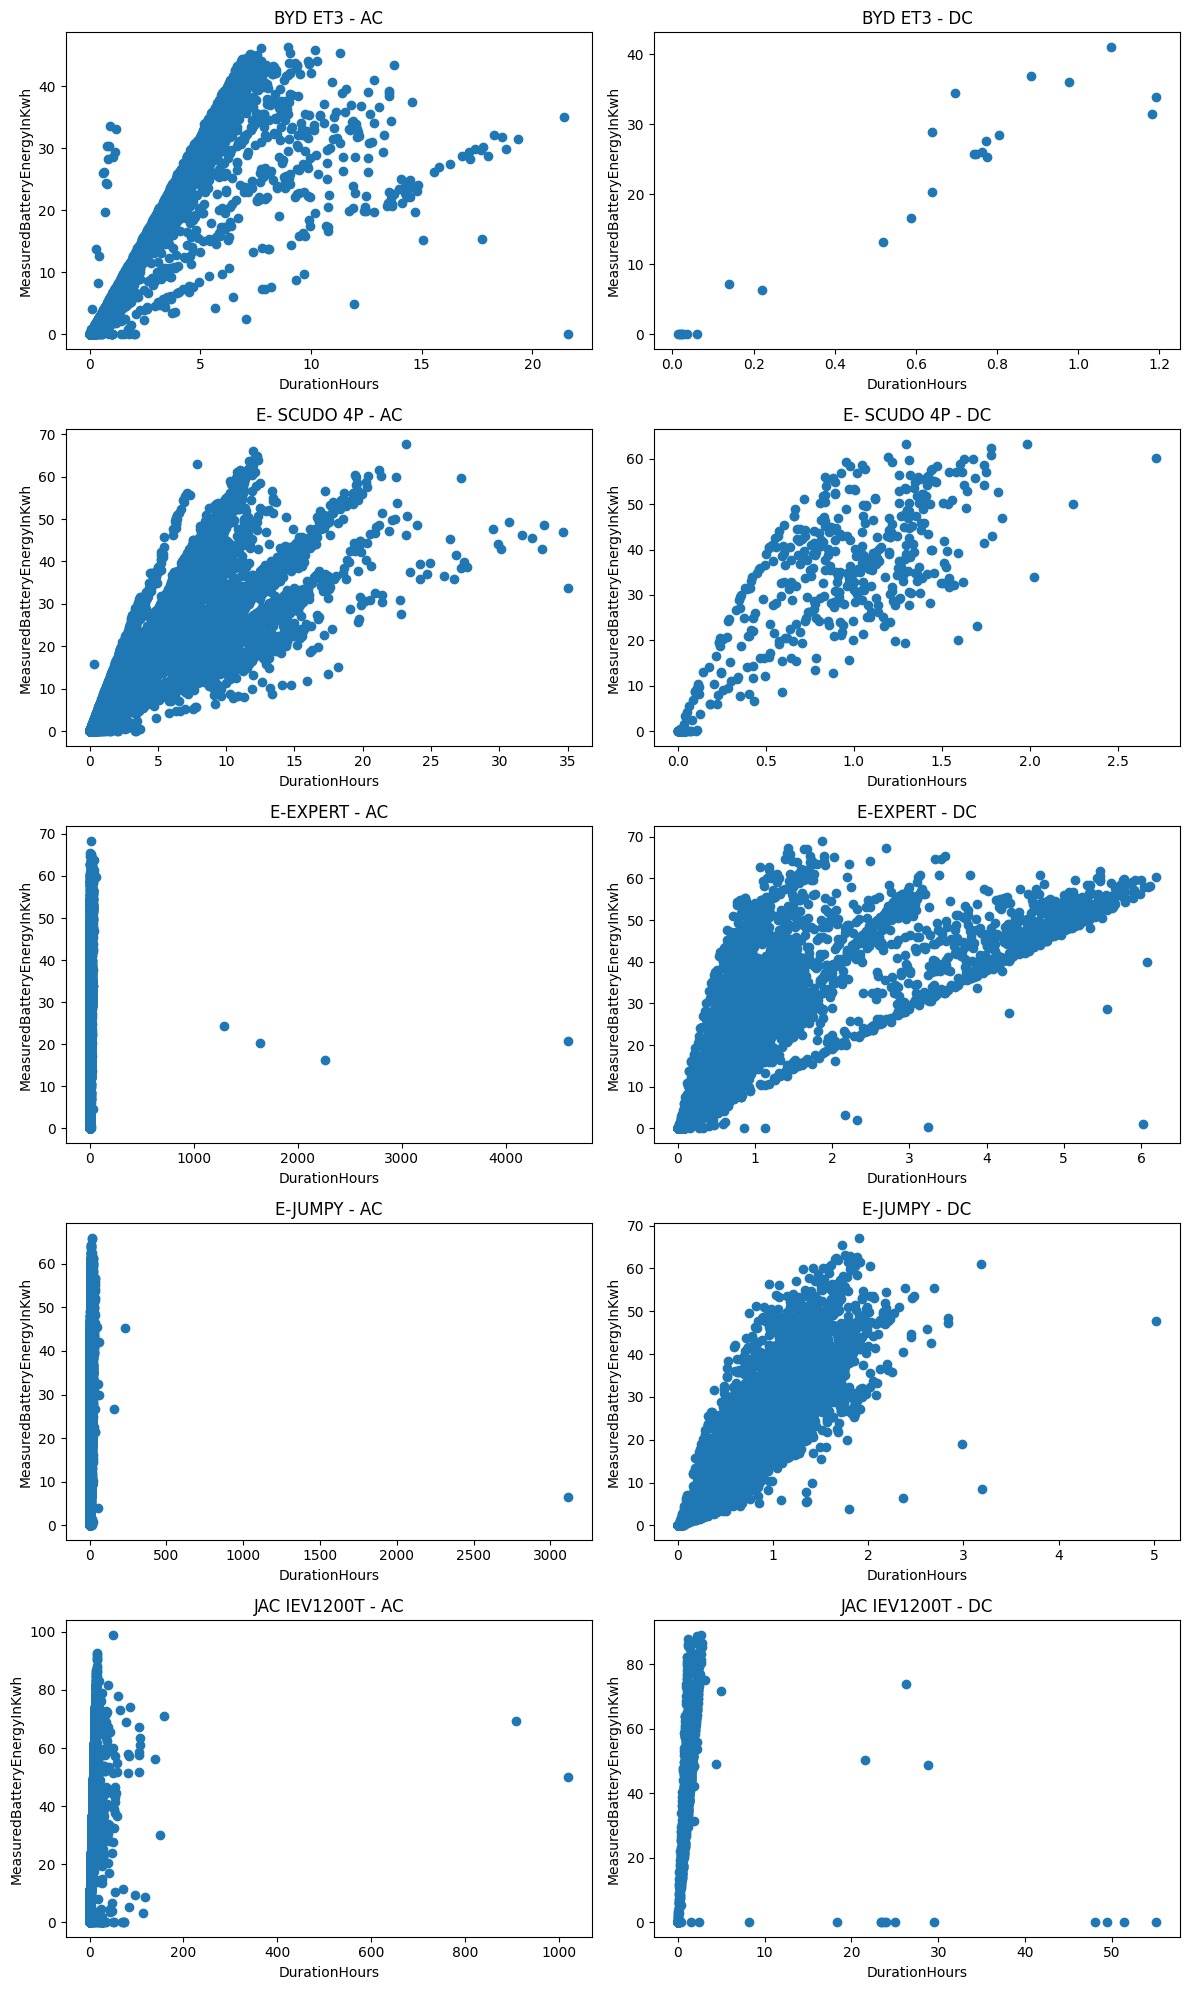

In [148]:
# Listando todas as combinações de ModeloCarro e ChargeType

combinacoes = df_recharge_filter_ranking.groupby(['ModeloCarro', 'ChargeType']).size().reset_index()[['ModeloCarro', 'ChargeType']]

# Definindo o tamanho da figura para o grid de gráficos

num_combinacoes = len(combinacoes)
num_cols = 2  
num_rows = (num_combinacoes + num_cols - 1) // num_cols  

# Criando o grid de scatter plots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
axes = axes.flatten()

# Iterar pelas combinações de ModeloCarro e ChargeType para criar os gráficos

for i, (modelo_carro, charge_type) in enumerate(combinacoes.values):
    df_filtered = df_recharge_filter_ranking[
        (df_recharge_filter_ranking['ModeloCarro'] == modelo_carro) &
        (df_recharge_filter_ranking['ChargeType'] == charge_type)
    ]
    
    # Criar o scatter plot para a combinação atual
    axes[i].scatter(df_filtered['DurationHours'], df_filtered['MeasuredBatteryEnergyInKwh'])
    
    # Adicionar título e rótulos aos gráficos
    axes[i].set_title(f"{modelo_carro} - {charge_type}")
    axes[i].set_xlabel('DurationHours')
    axes[i].set_ylabel('MeasuredBatteryEnergyInKwh')

# Remover eixos vazios se houver mais plots que espaços no grid
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar o layout
plt.tight_layout()
plt.show()


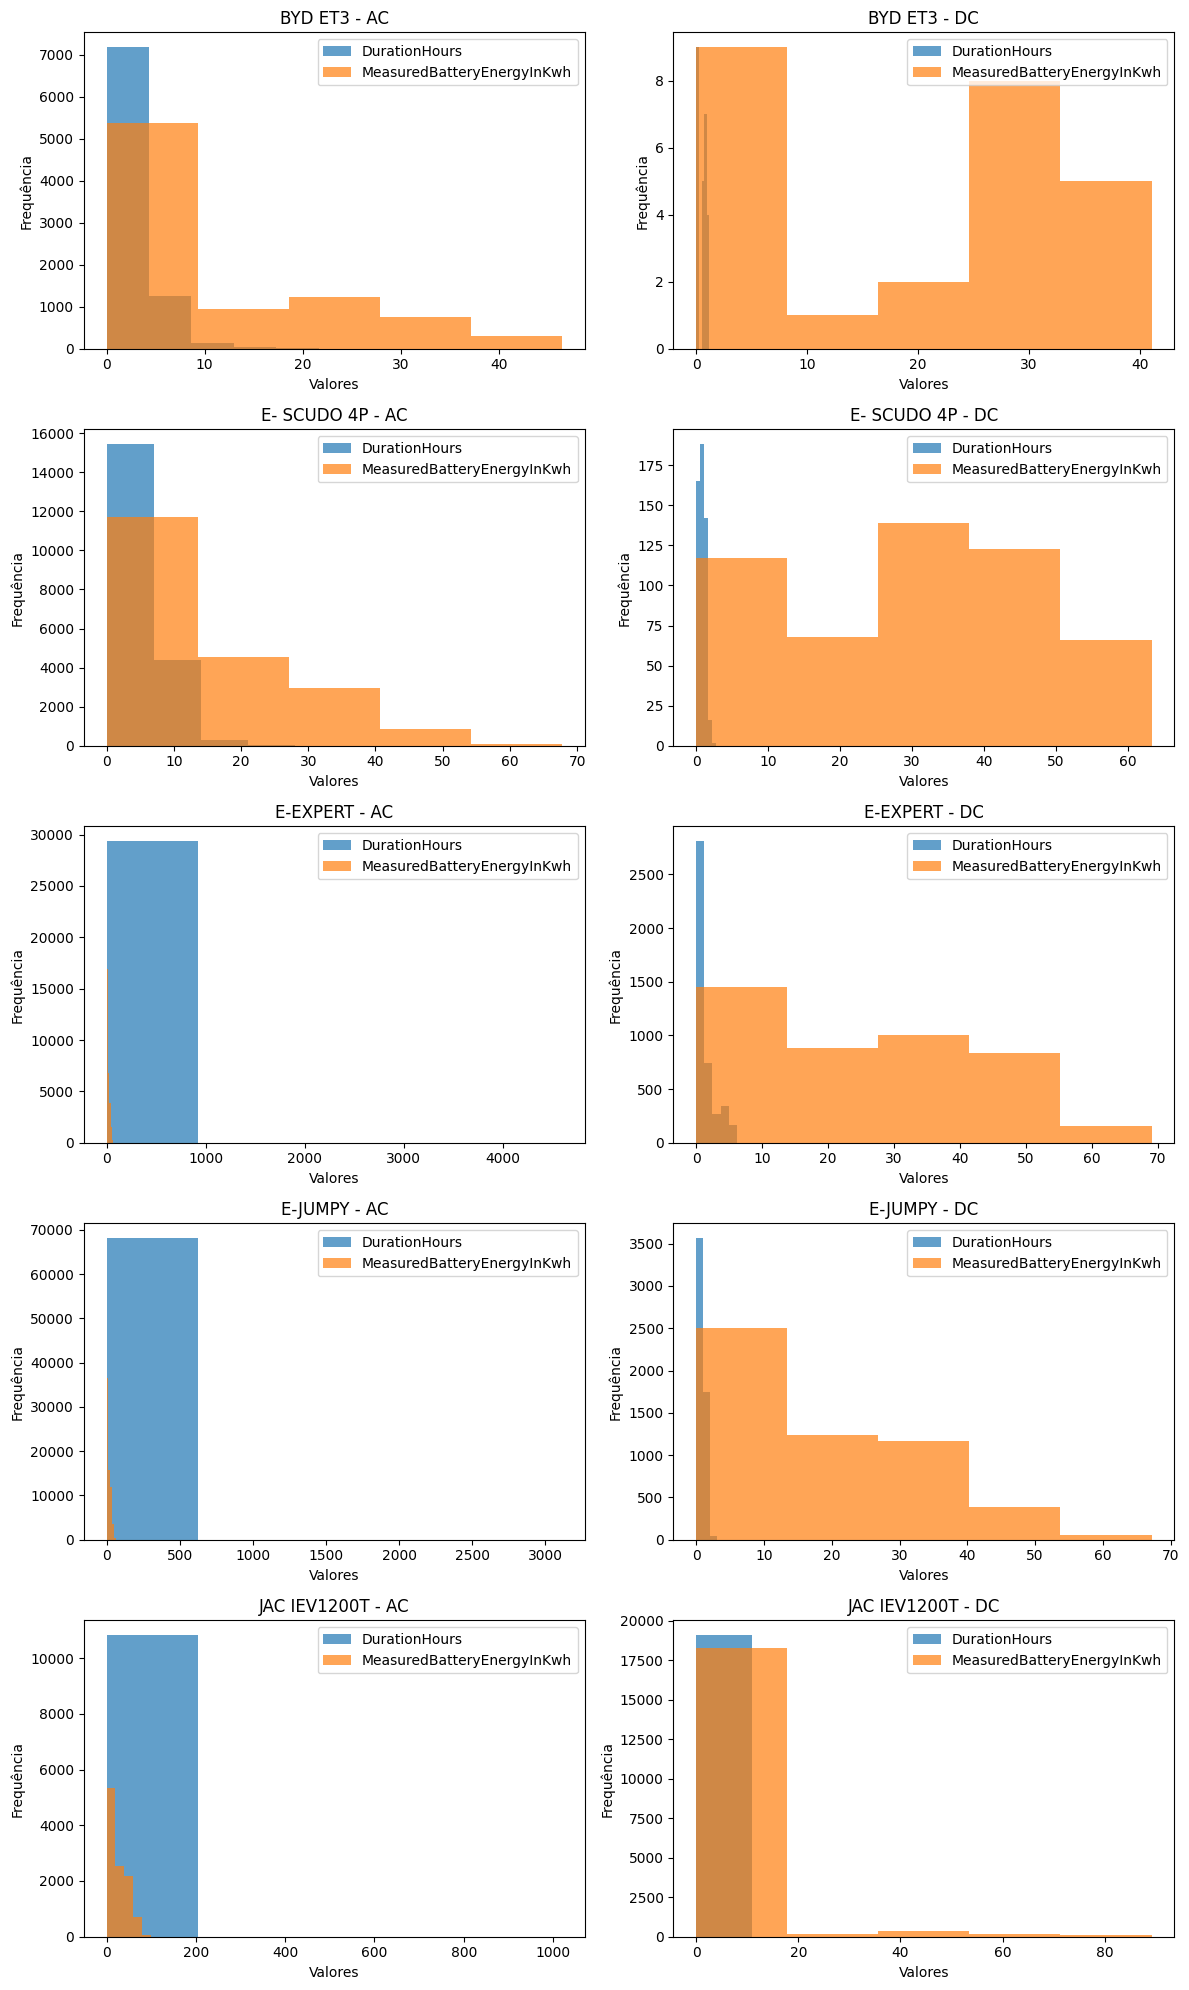

In [149]:
# Listando todas as combinações de ModeloCarro e ChargeType

combinacoes = df_recharge_filter_ranking.groupby(['ModeloCarro', 'ChargeType']).size().reset_index()[['ModeloCarro', 'ChargeType']]

# Definindo o tamanho da figura para o grid de gráficos

num_combinacoes = len(combinacoes)
num_cols = 2 
num_rows = (num_combinacoes + num_cols - 1) // num_cols 

# Criando o grid de histogramas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
axes = axes.flatten()

# Iterar pelas combinações de ModeloCarro e ChargeType para criar os gráficos
for i, (modelo_carro, charge_type) in enumerate(combinacoes.values):
    df_filtered = df_recharge_filter_ranking[
        (df_recharge_filter_ranking['ModeloCarro'] == modelo_carro) &
        (df_recharge_filter_ranking['ChargeType'] == charge_type)
    ]
    
    # Criar o histograma para a combinação atual
    axes[i].hist(df_filtered['DurationHours'], bins=5, alpha=0.7, label='DurationHours')
    axes[i].hist(df_filtered['MeasuredBatteryEnergyInKwh'], bins=5, alpha=0.7, label='MeasuredBatteryEnergyInKwh')

    # Adicionar título e rótulos aos gráficos
    axes[i].set_title(f"{modelo_carro} - {charge_type}")
    axes[i].set_xlabel('Valores')
    axes[i].set_ylabel('Frequência')
    axes[i].legend()

# Remover eixos vazios se houver mais plots que espaços no grid
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar o layout
plt.tight_layout()
plt.show()


In [150]:
# Sub Data Frames para realizar o tratamento nos dados

df_recharge_KANGOO = df_recharge_filter[ (df_recharge_filter['ModeloCarro'] == 'KANGOO Z.E. MAXI 2 LUGARES 2P' ) ]
df_recharge_JUMPY = df_recharge_filter[ (df_recharge_filter['ModeloCarro'] == 'E-JUMPY' ) ]
df_recharge_SCUDO = df_recharge_filter[ (df_recharge_filter['ModeloCarro'] == 'E- SCUDO 4P' ) ]
df_recharge_EXPERT = df_recharge_filter[ (df_recharge_filter['ModeloCarro'] == 'E-EXPERT' ) ]
df_recharge_IEV1200T = df_recharge_filter[ (df_recharge_filter['ModeloCarro'] == 'JAC IEV1200T' ) ]
df_recharge_BYDET3 = df_recharge_filter[ (df_recharge_filter['ModeloCarro'] == 'BYD ET3' ) ]

In [151]:
def remover_outliers(df):
    """
    Remove outliers de todas as colunas numéricas de um DataFrame usando o método IQR.

    Parâmetros:
    df (pd.DataFrame): DataFrame que contém os dados.

    A função modifica o DataFrame original removendo as linhas que contêm outliers em qualquer coluna numérica.
    """
    # Filtrar apenas as colunas numéricas do DataFrame
    df_numerico = df.select_dtypes(include=['number'])

    # Calculando o primeiro quartil (Q1) e o terceiro quartil (Q3) para todas as colunas numéricas
    Q1 = df_numerico.quantile(0.25)
    Q3 = df_numerico.quantile(0.75)
    IQR = Q3 - Q1

    # Definindo os limites de outliers para todas as colunas numéricas
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar o DataFrame para manter as linhas que estão dentro dos limites em todas as colunas numéricas
    df_filtrado = df[~((df_numerico < limite_inferior) | (df_numerico > limite_superior)).any(axis=1)]

    # Retornar o DataFrame filtrado (sem outliers)
    return df_filtrado

In [152]:
# Aplicando a função remover_outliers

df_recharge_KANGOO = remover_outliers(df_recharge_KANGOO)
df_recharge_JUMPY = remover_outliers(df_recharge_JUMPY)
df_recharge_SCUDO = remover_outliers(df_recharge_SCUDO)
df_recharge_EXPERT = remover_outliers(df_recharge_EXPERT)
df_recharge_IEV1200T = remover_outliers(df_recharge_IEV1200T)
df_recharge_BYDET3 = remover_outliers(df_recharge_BYDET3)

In [153]:
# Função para criar o grid de gráficos para comparação da remoção dos outliers

def plot_scatter_grid(dfs, x_col, y_col, charge_type_col, title="Grid de Gráficos de Dispersão"):
    """
    Cria um grid de gráficos de dispersão para múltiplos DataFrames.

    Parâmetros:
    dfs (list of pd.DataFrame): Lista de DataFrames a serem plotados.
    x_col (str): Coluna que será utilizada no eixo x de cada gráfico de dispersão.
    y_col (str): Coluna que será utilizada no eixo y de cada gráfico de dispersão.
    charge_type_col (str): Coluna para definir a cor dos pontos de dispersão.
    title (str): Título do gráfico.
    """
    # Número de DataFrames
    num_dfs = len(dfs)

    # Configurar o grid com 2 linhas e 3 colunas (2x3 = 6 subplots)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Ajustar o layout
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(pad=3.0)

    axes = axes.flatten()

    # Iterar pelos DataFrames e subplots
    for i, df in enumerate(dfs):
        scatter = axes[i].scatter(df[x_col], df[y_col], c=df[charge_type_col].astype('category').cat.codes, cmap='viridis')
        axes[i].set_title(f"DataFrame {i+1}")
        axes[i].set_xlabel(x_col)
        axes[i].set_ylabel(y_col)

    # Adicionar uma legenda para o gráfico
    fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02)

    # Remover qualquer gráfico não utilizado (se houver menos que 6 DataFrames)
    if num_dfs < 6:
        for i in range(num_dfs, 6):
            fig.delaxes(axes[i])

    plt.show()

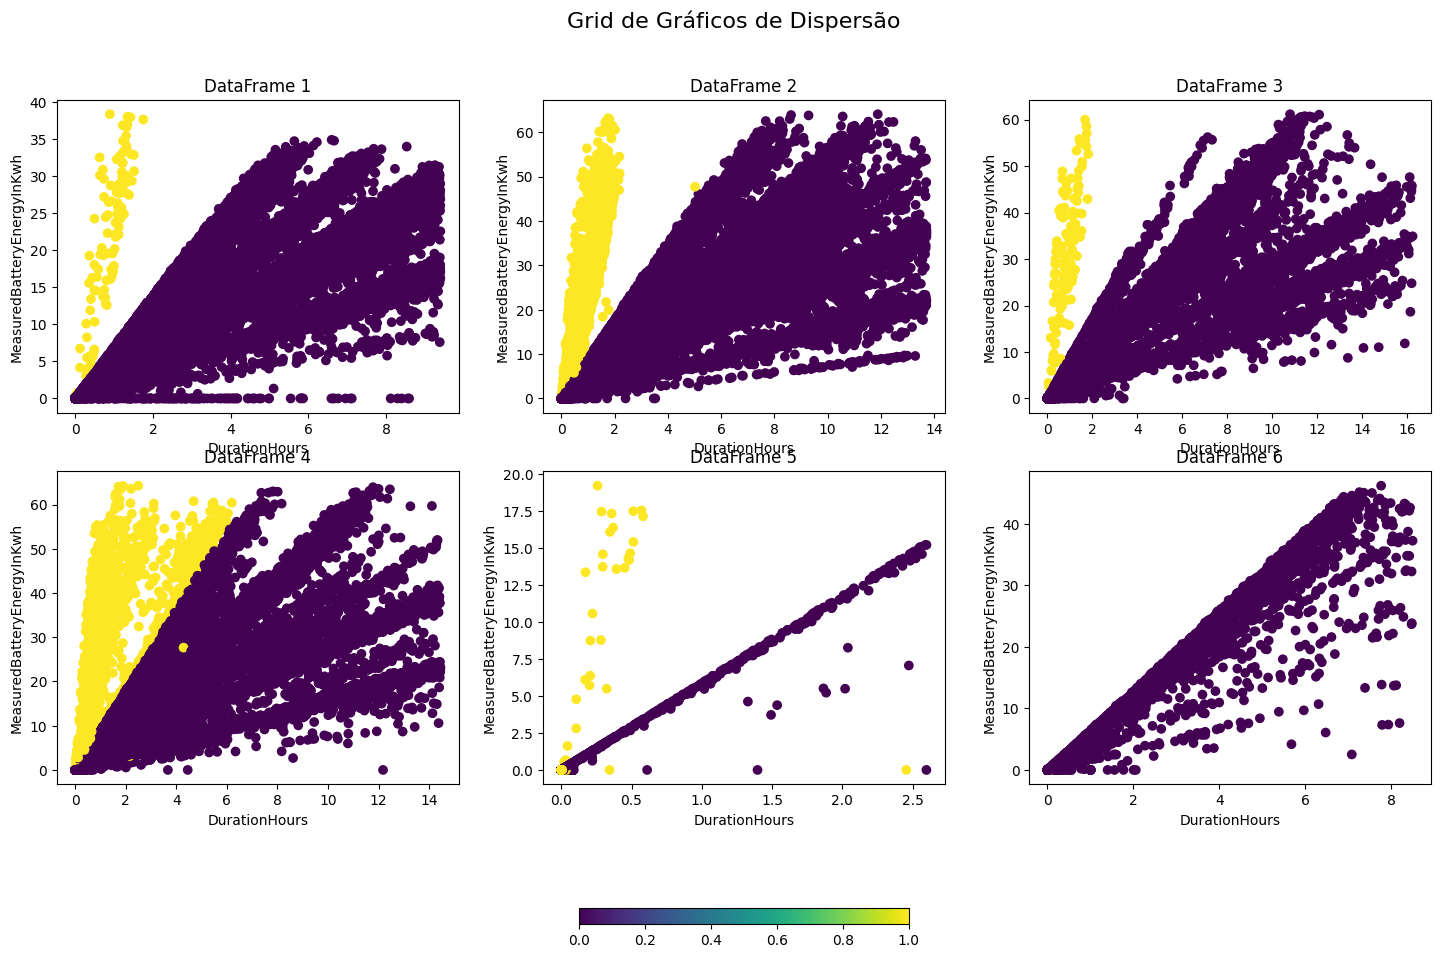

In [154]:
# Lista dos DF escolhidos

dfs = [df_recharge_KANGOO, df_recharge_JUMPY, df_recharge_SCUDO , df_recharge_EXPERT , df_recharge_IEV1200T, df_recharge_BYDET3]

# Colunas para o gráfico de dispersão

plot_scatter_grid(dfs, x_col='DurationHours', y_col='MeasuredBatteryEnergyInKwh', charge_type_col='ChargeType')

In [155]:
# Sub Data Frames para realizar o tratamento nos dados por tipo de carregamento

df_recharge_KANGOO_AC = df_recharge_KANGOO[ (df_recharge_filter['ChargeType'] == 'AC' ) ]
df_recharge_KANGOO_DC = df_recharge_KANGOO[ (df_recharge_filter['ChargeType'] == 'DC' ) ]

df_recharge_JUMPY_AC = df_recharge_JUMPY[ (df_recharge_filter['ChargeType'] == 'AC' ) ]
df_recharge_JUMPY_DC = df_recharge_JUMPY[ (df_recharge_filter['ChargeType'] == 'DC' ) ]

df_recharge_SCUDO_AC = df_recharge_SCUDO[ (df_recharge_filter['ChargeType'] == 'AC' ) ]
df_recharge_SCUDO_DC = df_recharge_SCUDO[ (df_recharge_filter['ChargeType'] == 'DC' ) ]

df_recharge_EXPERT_AC = df_recharge_EXPERT[ (df_recharge_filter['ChargeType'] == 'AC' ) ]
df_recharge_EXPERT_DC = df_recharge_EXPERT[ (df_recharge_filter['ChargeType'] == 'DC' ) ]

df_recharge_IEV1200T_AC = df_recharge_IEV1200T[ (df_recharge_filter['ChargeType'] == 'AC' ) ] # o JAC não precisaria, porém eu mantive só por padrão
df_recharge_IEV1200T_DC = df_recharge_IEV1200T[ (df_recharge_filter['ChargeType'] == 'DC' ) ]

df_recharge_BYDET3_AC = df_recharge_BYDET3[ (df_recharge_filter['ChargeType'] == 'AC' ) ]
df_recharge_BYDET3_DC = df_recharge_BYDET3[ (df_recharge_filter['ChargeType'] == 'DC' ) ]


In [156]:
# Função que executa a regressão linear nos dataframes selecionados 

def calcular_regressao(dataframes, nomes):
    """
    Calcula a regressão linear para uma lista de DataFrames e retorna um DataFrame 
    com os resultados (coeficiente, intercepto, MSE e R²) para cada DataFrame.

    Parâmetros:
    dataframes (list of pd.DataFrame): Lista de DataFrames para os quais a regressão será calculada.
    nomes (list of str): Lista com os nomes dos DataFrames, para identificação.

    Retorna:
    pd.DataFrame: DataFrame com o nome do DataFrame, coeficiente, intercepto, MSE e R².
    """
    resultados = []  # Lista para armazenar os resultados

    for i, df in enumerate(dataframes):
        # Separando as variáveis X e Y
        X = df[['DurationHours']]
        Y = df['MeasuredBatteryEnergyInKwh']

        # Dividindo os dados em conjuntos de treino e teste
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # Criando e treinando o modelo de regressão linear
        model = LinearRegression()
        model.fit(X_train, Y_train)

        # Fazendo previsões
        Y_pred = model.predict(X_test)

        # Avaliando o modelo
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = r2_score(Y_test, Y_pred)

        # Salvando os resultados em um dicionário
        resultados.append({
            'ModeloCarro': nomes[i],
            'Coeficiente': model.coef_[0],   # Pegando o coeficiente
            'Intercepto': model.intercept_,  # Pegando o intercepto
            'MSE': mse,                      # Mean Squared Error
            'R²': r2                         # R-Squared
        })

    # Convertendo os resultados para um DataFrame
    resultados_df = pd.DataFrame(resultados)
    return resultados_df

In [157]:
# EXECUTANDO A PREDIÇÃO 

# Lista de dataframes
dataframes = [df_recharge_KANGOO_AC, df_recharge_KANGOO_DC, df_recharge_JUMPY_AC, df_recharge_JUMPY_DC , df_recharge_SCUDO_AC , df_recharge_SCUDO_DC , df_recharge_EXPERT_AC , df_recharge_EXPERT_DC , df_recharge_IEV1200T_AC , df_recharge_IEV1200T_DC , df_recharge_BYDET3_AC , df_recharge_BYDET3_DC ]
nomes = ['KANGOO_AC','KANGOO_DC','JUMPY_AC','JUMPY_DC','SCUDO_AC','SCUDO_DC','EXPERT_AC','EXPERT_DC','IEV1200T_AC','IEV1200T_DC','BYDET3_AC','BYDET3_DC']

# Chamada da função
metricas_regressao = calcular_regressao(dataframes, nomes)

# Exibir os resultados
metricas_regressao.sort_values(by='R²', ascending=False)


,ModeloCarro,Coeficiente,Intercepto,MSE,R²
8,IEV1200T_AC,5.654358,-0.010129,0.354557,0.965380
10,BYDET3_AC,5.594083,0.109208,5.878404,0.961256
1,KANGOO_DC,22.676848,1.888385,12.389426,0.933544
3,JUMPY_DC,24.931456,0.703682,26.238736,0.893529
5,SCUDO_DC,30.628503,3.401744,58.688226,0.806955
4,SCUDO_AC,3.055062,2.047001,49.486430,0.748405
2,JUMPY_AC,3.443682,2.618633,56.726027,0.716507
0,KANGOO_AC,2.986493,2.693214,20.912775,0.696446
6,EXPERT_AC,3.017980,2.530404,71.078624,0.650632
7,EXPERT_DC,10.113401,9.370210,144.501714,0.596608


In [158]:
# RETORNANDO AS MÉTRICAS PARA O FORMATO DE TEXTO ORIGINAL  

metricas_regressao['ChargeType'] = metricas_regressao['ModeloCarro'].str.split('_').str[1]
metricas_regressao['ModeloCarro'] = metricas_regressao['ModeloCarro'].str.split('_').str[0]

metricas_regressao['ModeloCarro'] = metricas_regressao['ModeloCarro'].replace({
    'IEV1200T': 'JAC IEV1200T AT 4X2 2P',
    'BYDET3': 'BYD ET3',
    'KANGOO': 'KANGOO Z.E. MAXI 2 LUGARES 2P',
    'JUMPY': 'E-JUMPY',
    'SCUDO': 'E- SCUDO 4P',
    'EXPERT': 'E-EXPERT',
})

metricas_regressao.sort_values(by='R²', ascending=False)


,ModeloCarro,Coeficiente,Intercepto,MSE,R²,ChargeType
8,JAC IEV1200T AT 4X2 2P,5.654358,-0.010129,0.354557,0.965380,AC
10,BYD ET3,5.594083,0.109208,5.878404,0.961256,AC
1,KANGOO Z.E. MAXI 2 LUGARES 2P,22.676848,1.888385,12.389426,0.933544,DC
3,E-JUMPY,24.931456,0.703682,26.238736,0.893529,DC
5,E- SCUDO 4P,30.628503,3.401744,58.688226,0.806955,DC
4,E- SCUDO 4P,3.055062,2.047001,49.486430,0.748405,AC
2,E-JUMPY,3.443682,2.618633,56.726027,0.716507,AC
0,KANGOO Z.E. MAXI 2 LUGARES 2P,2.986493,2.693214,20.912775,0.696446,AC
6,E-EXPERT,3.017980,2.530404,71.078624,0.650632,AC
7,E-EXPERT,10.113401,9.370210,144.501714,0.596608,DC


In [159]:
# Função que cria o valor predito 

def aplicar_regressao(df, metricas_regressao, coluna_X, coluna_modelo, coluna_charge):
    """
    Aplica a regressão linear com base nas métricas de coeficiente e intercepto para cada linha de um DataFrame.
    Se não for encontrado o ModeloCarro e ChargeType no DataFrame de métricas, define os valores como -65536.

    Parâmetros:
    df (pd.DataFrame): DataFrame onde será aplicada a predição.
    metricas_regressao (pd.DataFrame): DataFrame contendo os coeficientes, intercepto e R² para cada combinação de ModeloCarro e ChargeType.
    coluna_X (str): Nome da coluna utilizada como variável independente (X).
    coluna_modelo (str): Nome da coluna que contém o ModeloCarro.
    coluna_charge (str): Nome da coluna que contém o ChargeType.

    Retorna:
    pd.DataFrame: O DataFrame original com duas novas colunas: 'valor_predito' e 'confiança'.
    """
    # Inicializar as novas colunas
    df['valor_predito'] = -65536
    df['confiança'] = -65536

    # Iterar sobre cada linha do DataFrame
    for index, row in df.iterrows():
        # Encontrar a linha correspondente nas métricas de regressão
        filtro_metricas = metricas_regressao[
            (metricas_regressao['ModeloCarro'] == row[coluna_modelo]) &
            (metricas_regressao['ChargeType'] == row[coluna_charge])
        ]

        # Verificar se encontramos o modelo e o tipo de carga correspondente
        if not filtro_metricas.empty:
            # Obter o coeficiente, intercepto e R² (confiança)
            coeficiente = filtro_metricas['Coeficiente'].values[0]
            intercepto = filtro_metricas['Intercepto'].values[0]
            r2 = filtro_metricas['R²'].values[0]

            # Calcular o valor predito usando a equação da regressão linear
            valor_predito = coeficiente * row[coluna_X] + intercepto

            # Atualizar as colunas 'valor_predito' e 'confiança'
            df.at[index, 'MeasuredBatteryEnergyInKwh_Predict'] = valor_predito
            df.at[index, 'Hit_Rate'] = r2
        else:
            # Se não encontrou, mantém o valor -65536 (que já foi inicializado)
            df.at[index, 'MeasuredBatteryEnergyInKwh_Predict'] = -65536
            df.at[index, 'Hit_Rate'] = -65536

    return df

In [160]:
# Ajustando os dados conforme o df de base de treinamento

df_recharge_sample = 'ChargeEvents_18_09.csv'
df_recharge_sample = pd.read_csv(df_recharge_sample)
colunas_objetivas = ['ModeloCarro','ChargeType','DurationTicks','StartStateOfCharge','EndStateOfCharge','MeasuredBatteryEnergyInKwh','PeakPowerKw']
df_recharge_sample = df_recharge_sample[colunas_objetivas]
df_recharge_sample['DeltaSOC'] = 100 - df_recharge_sample['StartStateOfCharge']
df_recharge_sample['DurationHours'] = df_recharge_sample['DurationTicks'] / 36000000000
df_recharge_sample['ModeloCarro'] = df_recharge_sample['ModeloCarro'].str.strip().str.upper()
warnings.filterwarnings('ignore')

In [161]:
# Criando um df usando a função aplicar_regressao

df_resultado = aplicar_regressao(df_recharge_sample, metricas_regressao, 'DurationHours', 'ModeloCarro', 'ChargeType')

In [162]:
# Exibir o DataFrame 

df_resultado.loc[(df_resultado['ModeloCarro'] == 'PARTNER RAPID BUSINESS PACK - MOTOR 1.4') ]

,ModeloCarro,ChargeType,DurationTicks,StartStateOfCharge,EndStateOfCharge,MeasuredBatteryEnergyInKwh,PeakPowerKw,DeltaSOC,DurationHours,valor_predito,confiança,MeasuredBatteryEnergyInKwh_Predict,Hit_Rate
34,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,71530000,100.000000,100.000,0.000000,-0.150000,0.000000,0.001987,-65536,-65536,-65536.0,-65536.0
38,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,990400000,100.000000,100.000,0.000000,-0.150000,0.000000,0.027511,-65536,-65536,-65536.0,-65536.0
39,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,5703130000,100.000000,100.000,0.000000,-0.552273,0.000000,0.158420,-65536,-65536,-65536.0,-65536.0
248,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,21462370000,56.000000,69.000,3.960000,NaN,44.000000,0.596177,-65536,-65536,-65536.0,-65536.0
249,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,21462370000,56.000000,69.000,3.960000,NaN,44.000000,0.596177,-65536,-65536,-65536.0,-65536.0
254,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,762370000,55.000000,56.000,0.110000,-0.201136,45.000000,0.021177,-65536,-65536,-65536.0,-65536.0
255,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,762370000,55.000000,56.000,0.110000,-0.201136,45.000000,0.021177,-65536,-65536,-65536.0,-65536.0
373,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,436159700000,65.500000,95.000,18.230000,-0.471591,34.500000,12.115547,-65536,-65536,-65536.0,-65536.0
374,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,399247869999,55.500000,100.000,28.790001,-0.456818,44.500000,11.090219,-65536,-65536,-65536.0,-65536.0
388,PARTNER RAPID BUSINESS PACK - MOTOR 1.4,AC,10442570000,64.500000,65.500,0.440000,-0.471591,35.500000,0.290071,-65536,-65536,-65536.0,-65536.0
